### 목표: 생선 품종 분류 모델
 - 데 이 터 : 2가지 품종의 생선 데이터 fish.csv
  - feature : Weight, Length
  - target  : Species
  - 유    형: 지도학습 / 분류
   

1. 모듈 로딩, 데이터 준비

In [155]:
import pandas as pd                                 #데이터파일 관련모듈
from sklearn.neighbors import KNeighborsClassifier  #기계학습 관련 모듈

In [180]:
data = '../data/fish.csv'

#5개의 feature/특성 중 2개 선택
fishDF = pd.read_csv(data, usecols=[0,1,2])

fishDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length   159 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.9+ KB


In [183]:
# Bream, Smelt 품종 행만 추출
mask = fishDF.Species.isin(['Bream', 'Smelt']) # Boolean indexing

# 해당 행만 도출
twoFishDF=fishDF[mask] # species가 bream, smelt인 것만 필터링 하여 도출

# 인덱스 정리
twoFishDF.reset_index(drop=True, inplace=True)

In [184]:
# Bream, Smelt 품종명 수치화
# twoFishDF['Species']=twoFishDF['Species'].replace({'Bream':0, 'Smelt':1})
twoFishDF.loc[:,'Species'] = twoFishDF['Species'].replace({'Bream':0, 'Smelt':1}).copy()
twoFishDF.head()


,Species,Weight,Length
0,0,242.0,25.4
1,0,290.0,26.3
2,0,340.0,26.5
3,0,363.0,29.0
4,0,430.0,29.0


In [186]:
twoFishDF['Species'] = twoFishDF['Species'].astype(int).copy()
twoFishDF.dtypes

C:\Users\kdp\AppData\Local\Temp\ipykernel_13500\3450856886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoFishDF['Species'] = twoFishDF['Species'].astype(int).copy()


Species      int32
Weight     float64
Length     float64
dtype: object

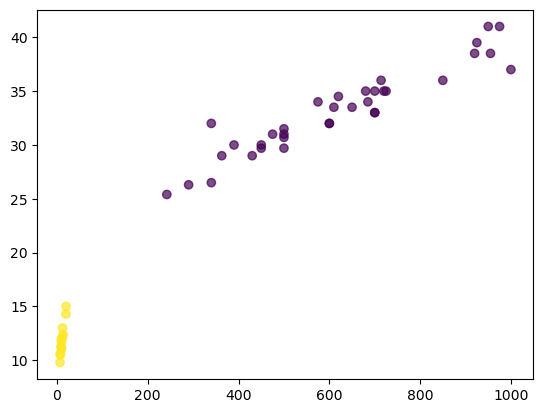

In [187]:
#Weight, Length로 품종 구별이 가능한지 시각화 확인
import matplotlib.pyplot as plt

plt.scatter(twoFishDF['Weight'], twoFishDF['Length'], c = twoFishDF.Species, alpha=0.7)

    3. 기계학습을 위한 데이터 준비
 - feature / 특성 + target/label/class
  - 학습용 데이터셋 : 80 %
    - 테스트용      : 20 % 

3-1. 직접 target / label 컬럼의 비율을 고려하여 학습 & 테스트 데이터셋 준비

In [188]:
#학습과 테스트비율 조절갯수 계산
num = round(twoFishDF.shape[0] * 0.8)

# 학습 데이터셋 추출
trainDF = twoFishDF.iloc[:num+1]
print(f"trainDF.shape: {trainDF.shape}")

# 테스트 데이터셋 추출
testDF = twoFishDF.iloc[num:]
print(f"testDF.shape: {testDF.shape}")

trainDF.shape: (40, 3)
testDF.shape: (10, 3)


In [189]:
#데이터 섞기: 100% 모두 섞기
#안 섞으면 학습은 Bream 위주로 해버림: 테스트는 다른 종 위주로 할 거라서 의미가 없긔. 

twofishDF = twoFishDF.sample(frac = 1.)
twofishDF

,Species,Weight,Length
10,0,475.0,31.0
29,0,1000.0,37.0
30,0,920.0,38.5
23,0,680.0,35.0
13,0,340.0,32.0
26,0,720.0,35.0
19,0,650.0,33.5
39,1,9.8,11.2
35,1,6.7,9.8
27,0,714.0,36.0


3-2. scikit - learn 모듈 활용한 학습용 테스트용 데이터셋 준비
- 추가모듈로딩

In [190]:
from sklearn.model_selection import train_test_split

In [191]:
featureDF = twoFishDF[twoFishDF.columns[1:]]
targetSR = twoFishDF.Species

print(f'featureDF = {featureDF.shape}\n {featureDF.head(2)}')
print(f'targetSR = {targetSR.shape} \n {targetSR.head(2)}')

featureDF = (49, 2)
    Weight  Length
0   242.0    25.4
1   290.0    26.3
targetSR = (49,) 
 0    0
1    0
Name: Species, dtype: int32


In [192]:
#비율 설정 없이 학습/테스트셋 분리
#[전달]: feature data, target data
#[기본] shuffle = True, train:test = 0.75 : 0.25
#[반환] 학습용 feature, 테스트용 feature, 학습용 target, 테스트용 target

X_train, X_test, Y_train, Y_test = train_test_split(featureDF, targetSR)

In [193]:
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(X_train.head(2), Y_train.head(2),sep='\n')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
print(X_test.head(2), Y_test.head(2), sep='\n')

X_train:(36, 2), Y_train:(36,)
    Weight  Length
45    13.4    12.4
13   340.0    32.0
45    1
13    0
Name: Species, dtype: int32
X_test:(13, 2), Y_test:(13,)
    Weight  Length
19   650.0    33.5
22   620.0    34.5
19    0
22    0
Name: Species, dtype: int32


In [194]:
#비율 설정하여 학습/테스트셋 분리
#[전달]: feature data, target data
#[기본] shuffle = True, train:test = 0.8 : 0.2
#[설정] train:test = 0.8 : 0.2 -> test_size, train_size 설정
#       분류의 경우: target이 불균형일 때 비율 지정하는 매개변수 statify 매개변수를 target으로 설정
#[반환] 학습용 feature, 테스트용 feature, 학습용 target, 테스트용 target

x_train, x_test, y_train, y_test = train_test_split(featureDF, targetSR)

print(f'x_train : {x_train.shape}, y_train : {y_train.shape}')
print()
print(x_train.head(2), y_train.head(2), sep='\n')
print()
print(f'x_test : {x_test.shape}, y_test : {y_test.shape}')
print()
print(x_test.head(2), y_test.head(2), sep='\n')

x_train : (36, 2), y_train : (36,)

    Weight  Length
37     7.0    10.6
28   850.0    36.0
37    1
28    0
Name: Species, dtype: int32

x_test : (13, 2), y_test : (13,)

    Weight  Length
44    12.2    12.2
16   700.0    33.0
44    1
16    0
Name: Species, dtype: int32


In [195]:
# 타겟/클래스 비율
print(y_train.value_counts()/y_train.shape[0])
print(y_test.value_counts()/y_test.shape[0])

Species
0    0.694444
1    0.305556
Name: count, dtype: float64
Species
0    0.769231
1    0.230769
Name: count, dtype: float64


In [196]:
## -- 비율 설정과 함께 학습/테스트 셋 분리 - 1
## -- [전달] 피쳐 데이터, 타겟 데이터
## -- [기본] shuffle = True
## -- [설정] train:test = 0.9:0.1 => test_size, train_size 매개변수 값 설정
## -- [반환] 학습용 피쳐, 태스트용 피쳐, 학습용 타겟, 테스트용 타겟
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.1)

#test_size 나 train_size 중 1개의 값을 정해주면 거기서 뺀 거를 다른 거의 사이즈로 자동 설정됨
#근데 이렇게 해도 종 종류별로 그 비율을 맞춰주지는 않는다는 문제점이 발생

In [197]:
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
#print(X_train.head(2), Y_train.head(2),sep='\n')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
#print(X_test.head(2), Y_test.head(2), sep='\n')
print(f'\nX_test : {X_test.shape}, Y_test : {Y_test.shape}')

X_train:(44, 2), Y_train:(36,)
X_test:(5, 2), Y_test:(13,)

X_test : (5, 2), Y_test : (13,)


In [198]:
## -- 비율 설정과 함께 학습/테스트 셋 분리 - 2
## -- [전달] 피쳐 데이터, 타겟 데이터
## -- [기본] shuffle = True
## -- [설정] train:test = 0.9:0.1 => test_size, train_size 매개변수 값 설정
## --       분류의 경우 target이 불균형일 경우 비율 지정하는 stratify 매개변수를 target으로 설정
## -- [반환] 학습용 피쳐, 태스트용 피쳐, 학습용 타겟, 테스트용 타겟
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size=0.1, stratify=targetSR)
print(f"X_train : {X_train.shape}")
print(X_train.head(2))
print()
print(f"y_train : {y_train.shape}")
print(y_train.head(2))
print()
print(f"X_test : {X_test.shape}")
print(X_test.head(2))
print()
print(f"y_test : {y_test.shape}")
print(y_test.head(2))

X_train : (44, 2)
    Weight  Length
21   685.0    34.0
15   600.0    32.0

y_train : (44,)
21    0
15    0
Name: Species, dtype: int32

X_test : (5, 2)
    Weight  Length
5    450.0    29.7
39     9.8    11.2

y_test : (5,)
5     0
39    1
Name: Species, dtype: int32


In [199]:
# 타겟/클래스 비율
print(y_train.value_counts()/y_train.shape[0])
print(y_test.value_counts()/y_test.shape[0])

Species
0    0.704545
1    0.295455
Name: count, dtype: float64
Species
0    0.8
1    0.2
Name: count, dtype: float64


In [200]:
### 검증용 데이터셋 준비 ==> 학습용 데이터셋에서 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)
print(f"X_train : {X_train.shape}")
print(X_train.head(2))
print()
print(f"y_train : {y_train.shape}")
print(y_train.head(2))
print()
print(f"X_val : {X_val.shape}")
print(X_test.head(2))
print()
print(f"y_val : {y_val.shape}")
print(y_test.head(2))

X_train : (39, 2)
    Weight  Length
3    363.0    29.0
18   610.0    33.5

y_train : (39,)
3     0
18    0
Name: Species, dtype: int32

X_val : (5, 2)
    Weight  Length
5    450.0    29.7
39     9.8    11.2

y_val : (5,)
5     0
39    1
Name: Species, dtype: int32


4. 학습 진행
- 학습 방법: 지도학습 / 분류 => KNN
- 모델 인스턴스 생성=> fit() 메서드

In [201]:
# 모델 인스턴스 생성
model = KNeighborsClassifier()
model

KNeighborsClassifier()

In [202]:
# 학습 진행: 학습용 데이터 진행
model.fit(X_train, y_train)

KNeighborsClassifier()

5. test: 학습에 사용되지 않은 데이터로 진행

In [203]:
model.score(X_val, y_val)

1.0

In [204]:
model.predict(X_test)

array([0, 1, 0, 0, 0])

In [205]:
y_test

5     0
39    1
14    0
6     0
9     0
Name: Species, dtype: int32

6-1. 사용자로부터 전달받은 새로운 데이터에 대한 예측-> 학습할 때 전달되는 feature와 동일한 형태

In [206]:
# 길이 25, 무게 160인 생선의 품종 예측
newdata = pd.DataFrame([[160,25]], columns= twoFishDF.columns[1:])

In [208]:
import matplotlib.pyplot as plt

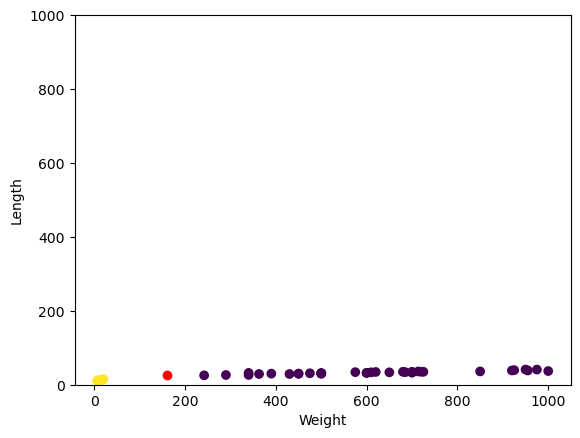

In [216]:
# 새로운 데이터 시각화
plt.plot(newdata.Weight, newdata.Length, 'ro')

# 학습 데이터 시각화
plt.scatter(twoFishDF.Weight, twoFishDF.Length, c = twoFishDF.Species)
plt.xlabel('Weight')
plt.ylabel('Length')
plt.ylim(0,1000)
plt.show()

In [210]:
# 생성된 모델로 새로운 데이터 품종 예측
model.predict(newdata)

array([1])

In [214]:
# 새로운 데이터의 최근접 데이터 추출
_, index = model.kneighbors(newdata) #둘 중 어느 하나만 알고 싶을 때는 필요없는 정보를 _로 치환.

index.tolist()[0] #index는 2차원 데이터이기때문에 [0]으로 추출.
#index는 2차원 데이터이기때문에 [0]으로 추출.

[16, 26, 38, 18, 35]

In [215]:
twoFishDF.iloc[index.tolist()[0]]

,Species,Weight,Length
16,0,700.0,33.0
26,0,720.0,35.0
38,1,9.7,11.0
18,0,610.0,33.5
35,1,6.7,9.8
